In [4]:
import torch
from torch import nn
from tqdm import tqdm
from collections import defaultdict
import pickle,json,math
import matplotlib.pyplot as plt
import numpy as np
import torch.serialization
torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])
L=[]
# ✔️
def truncate_pad(line, num_steps, padding_token):
    """截断或者填充序列,以保证序列长度一致"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

# ✔️
class FFN(nn.Module):
    """
    基于位置的前馈网络,仅改变输入的最后一个维度
    """

    def __init__(self, ffn_num_inputs, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(FFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_inputs, ffn_num_hiddens)
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

#✔️
class AddNorm(nn.Module):
    """层归一化"""

    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.LN = nn.LayerNorm(normalized_shape)

    def forward(self, X, y):
        return self.LN(self.dropout(y) + X)

#✔️
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

# ✔️
def masked_softmax(X, valid_lens):
    """
    有掩码的 softmax,以消除pad或者无关因素的影响
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, X.shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# ✔️
class AdditiveAttention(nn.Module):
    """加性注意力"""

    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        quaries, keys = self.W_q(queries), self.W_k(keys)
        features = quaries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# ✔️
class DotProductAttention(nn.Module):
    """缩放点积注意力"""

    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        dim = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(dim)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# ✔️
def transpose_qkv(X, num_heads):
    """transform shape"""
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

# ✔️
def transpose_output(X, num_heads):
    """反变换"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

# ✔️
def grad_clipping(net, theta):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# ✔️
class Accumulator():
    def __init__(self, num):
        self.Record = [0] * num

    def add(self, *args):
        if args:
            for i in range(len(args)):
                self.Record[i] += args[i]

    def __getitem__(self, idx):
        return self.Record[idx]

# ✔️
class MultiHeadAttention(nn.Module):
    """"多头注意力"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output = transpose_output(output, self.num_heads)
        return self.W_o(output)

# ✔️
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # 预计算所有可能的位置编码
        P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        P[:, :, 0::2] = torch.sin(X)
        P[:, :, 1::2] = torch.cos(X)
        self.register_buffer('P', P)   # 不参与梯度，但会随模型保存

    def forward(self, X, offset=0):
        """
        X: (batch_size, seq_len, num_hiddens)
        offset: 当前解码步的起始位置（训练时=0，预测时=0,1,2,...）
        """
        X = X + self.P[:, offset:offset + X.shape[1], :].to(X.device)
        return self.dropout(X)

# ✔️
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# ✔️
class MaskedSoftmaxLoss(nn.CrossEntropyLoss):
    """
    带遮蔽的softmax交叉熵损失函数
    """
    def forward(self, pred, label, valid_lens):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_lens)
        self.reduction = "none"
        unweighted_loss = super(MaskedSoftmaxLoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

# ✔️
def bleu(pred_seq, label_seq, k):
    """
    计算 BLEU Score
    """
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[" ".join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[" ".join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[" ".join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

# ✔️
def train(net, train_iter, lr, num_epochs, src_vocab, tgt_vocab, device, num_steps,Go=False,samples=None):
    def init_weight(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weight)
    net = net.to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxLoss()
    net.train()
    start_epoch=0
    global L
    if Go:
        start_epoch,L=load_checkpoint(net, optim)
        start_epoch+=1
    if torch.cuda.device_count()>1:
        net=nn.DataParallel(net)
    for epoch in tqdm(range(start_epoch,num_epochs), desc=f"<training>🤫"):
        metric = Accumulator(2)
        for batch in train_iter:
            net.train()
            optim.zero_grad()
            X, X_valid_lens, y, y_valid_lens = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab["<bos>"]] * y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, y[:, :-1]], 1)
            y_label=y
            y_pred, _ = net(X, dec_input, X_valid_lens)
            l = loss(y_pred, y_label, y_valid_lens)
            l.sum().backward()
            grad_clipping(net, 1)
            optim.step()
            with torch.no_grad():
                num_tokens = y_valid_lens.sum()
                metric.add(l.sum(), num_tokens)
        temp=metric[0] / metric[1]
        L.append(temp.cpu().numpy())
        save_checkpoint(net, optim, epoch,L)
        if epoch%10==0:
            print(f"Current Loss is {temp:.3f}\n")
    Eval(num_epochs,net, src_vocab, tgt_vocab, num_steps, device,samples)

# ✔️
def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    net.eval()
    model = net.module if hasattr(net, 'module') else net
    encoder = model.encoder
    decoder = model.decoder

    # 编码器部分不变
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = encoder(enc_X, enc_valid_len)
    dec_state = decoder.init_state(enc_outputs, enc_valid_len)

    dec_X = torch.tensor([[tgt_vocab['<bos>']]], device=device)
    output_seq = []

    for t in range(num_steps):           # t 就是当前步的 offset
        Y, dec_state = decoder(dec_X, dec_state, offset=t)   # 关键！传 t
        next_token = Y.argmax(dim=2)
        pred = next_token.item()
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        dec_X = next_token  # Teacher forcing off，用自己的预测

    return ' '.join(tgt_vocab.to_tokens(output_seq))


def Eval(num_epochs,net, src_vocab, tgt_vocab, num_steps, device,samples=None):
    if not samples:
        samples = [('go .', 'va !'),
                 ('hi .', 'salut !'),
                 ('run !', 'cours !'),
                 ('hello .', 'bonjour .'),
                 ('i won !', "j'ai gagné !"),
                 ("i'm ok .", 'je vais bien .'),
                 ('thank you .', 'merci .'),
                 ('are you ok ?', 'ça va ?'),
                 ("i'm home .", 'je suis rentré .'),
                 ('we won .', 'nous avons gagné .')]
    metric=Accumulator(2)
    for src,tgt in samples:
        pred=predict(net, src, src_vocab, tgt_vocab, num_steps, device)
        Single_bleu=bleu(pred,tgt,2)
        print(f"{pred:30}-------->,{tgt:30}\t\t{Single_bleu:.4f}")
        metric.add(1,Single_bleu)
    print(f"\nOverall_score is {metric[1]/metric[0]:.4f}")

    # display
    plt.plot(np.arange(1, num_epochs + 1), L, "b-o")
    plt.title("Loss of epoches")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.savefig(r"./image/Loss.png")
    plt.show()


In [13]:
def save_checkpoint(model, optimizer, epoch,L, path="./storage/checkpoint.pt"):
    torch.save({
        "model": model.module.state_dict() if torch.cuda.device_count()>1 else model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        'loss_history': L,
    }, path)


def load_checkpoint(model, optimizer, path="./storage/checkpoint.pt"):
    print("loading...")
    checkpoint = torch.load(path, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    print(f"Resumed from epoch {checkpoint['epoch']} ")
    return checkpoint["epoch"],checkpoint["loss_history"]

In [6]:
from torch import nn
import math

#✔️
class EncoderBlock(nn.Module):
    """编码块"""
    def __init__(self,key_size,query_size,value_size,num_hiddens,
                norm_shape,ffn_num_inputs,ffn_num_hiddens,
                num_heads,dropout,use_bias=False,**kwargs):
        super(EncoderBlock,self).__init__(**kwargs)
        self.attention=MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout,use_bias)
        self.addnorm1=AddNorm(norm_shape,dropout)
        self.ffn=FFN(ffn_num_inputs,ffn_num_hiddens,num_hiddens)
        self.addnorm2=AddNorm(norm_shape,dropout)

    def forward(self,X,valid_lens):
        # 要求 key_size==num_hiddens
        y=self.addnorm1(X,self.attention(X,X,X,valid_lens))
        # <output>shape: (batch,query_num,num_hiddens)
        return self.addnorm2(y,self.ffn(y))

#✔️
class TransformerEncoder(nn.Module):
    """Encoer( core )🤫"""
    def __init__(self,vocab_size,key_size,query_size,value_size,num_hiddens,
                norm_shape,ffn_num_inputs,ffn_num_hiddens,num_heads,num_layers,dropout,use_bias=False,**kwargs):
        super(TransformerEncoder,self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.embedding=nn.Embedding(vocab_size,num_hiddens)
        self.pos_encoding=PositionalEncoding(num_hiddens,dropout)
        self.blks=nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"block_{i}",EncoderBlock(key_size,query_size,value_size,num_hiddens,
                                                          norm_shape,ffn_num_inputs,ffn_num_hiddens,num_heads,
                                                          dropout,use_bias))

    def forward(self,X,valid_lens,*args):
        # 防止输入信号由顺序信号占主导，导致噪声特别大无法训练
        X=self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X=blk(X,valid_lens)
        return X






In [7]:
import torch
from torch import nn
import math

#✔️
class DecoderBlock(nn.Module):
    """解码器块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_inputs, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = FFN(ffn_num_inputs, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        """解码器需要编码器提取的全局特征state以及当前输入特征"""
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat([state[2][self.i], X], axis=1)
        state[2][self.i] = key_values
        # training属性是nn.Module自动维护的，当你shezhiModel.train()的时候该属性就会被自动设置为True
        # module.training = True
        if self.training:
            # 生成 mask 掩码，用于训练的时候遮蔽后面的词元
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+ 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # 在这里，X作为 query ，key_values作为键值对，表示 key_values的每个位置对当前查询的影响权重
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        y = self.addnorm1(X, X2)
        # enc_outputs shape:(batch,query_num,num_hiddens)
        y2 = self.attention2(y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(y, y2)
        return self.addnorm3(Z, self.ffn(Z)), state

#✔️
class TransformerDecoder(nn.Module):
    def __init__(self,vocab_size,key_size,query_size,value_size,num_hiddens,norm_shape,\
                ffn_num_inputs,ffn_num_hiddens,num_heads,num_layers,dropout,**kwargs):
        super(TransformerDecoder,self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.num_layers=num_layers
        self.embedding=nn.Embedding(vocab_size,num_hiddens)
        self.pos_encoding=PositionalEncoding(num_hiddens,dropout)
        self.blks=nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"block_{i}",DecoderBlock(key_size,query_size,value_size,num_hiddens,\
                                                           norm_shape, ffn_num_inputs,ffn_num_hiddens,\
                                                           num_heads,dropout,i))
        self.dense=nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs,enc_valid_lens,*args):
        return [enc_outputs,enc_valid_lens,[None]*self.num_layers]
    
    def forward(self, X, state, offset=0):   # 新增 offset 参数
            X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens), offset)
            for i, blk in enumerate(self.blks):
                X, state = blk(X, state)
            return self.dense(X), state

In [8]:
from collections import Counter
from torch.utils.data import TensorDataset,DataLoader
import torch
import os

def read_data():
    """载入“英语－法语”数据集"""
    data_dir = "../data/fra-eng"
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        return f.read()

def preprocess(text):
    def no_space(char, prev_char):
        return char in set(',.!?„“;:') and prev_char != ' '
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts)>=2:
            source.append(parts[0].lower().split(' '))
            target.append(parts[1].lower().split(' '))
    return source, target


class Vocab:
    """建立词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = self.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = ["<unk>"] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """token->idx"""
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """idx->token"""
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

    def count_corpus(self, tokens):
        """统计词元频率"""
        if len(tokens)==0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # tokens应该是一个列表形式
        return Counter(tokens)

def load_array(src_vocab,tgt_vocab,src,tgt,batch_size,num_steps,is_train=True):
    def build_array(lines, vocab, num_steps):
        lines = [vocab[l] for l in lines]
        lines = [l + [vocab['<eos>']] for l in lines]
        array = torch.tensor([
            truncate_pad(l, num_steps, vocab['<pad>']) for l in lines
        ])  # shape: (N, num_steps)

        valid_lens = (array != vocab['<pad>']).sum(1)
        return array, valid_lens


    def truncate_pad(line,num_steps,padding_token):
        """截断或者填充序列，以保证序列长度一致"""
        if len(line)>num_steps:
            return line[:num_steps]
        return line+[padding_token]*(num_steps-len(line))

    # 导入
    src_array,src_valid_lens=build_array(src,src_vocab,num_steps)
    tgt_array,tgt_valid_lens=build_array(tgt,tgt_vocab,num_steps)
    data_arrays=(src_array,src_valid_lens,tgt_array,tgt_valid_lens)

    return DataLoader(TensorDataset(*data_arrays),batch_size,shuffle=is_train)

def load_data(batch_size, num_steps, num_examples=None):
    """
    :param batch_size:
    :param num_steps:
    :param num_examples:
    :return: train_iter,test_iter,val_iter,src_vocab,tgt_vocab
    """
    text = read_data()
    train_src, train_tgt = tokenize(preprocess(text),num_examples)

    # 建立词表，接下来应该转换词元
    src_vocab = Vocab(train_src, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    tgt_vocab = Vocab(train_tgt, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])

    train_iter = load_array(src_vocab, tgt_vocab, train_src, train_tgt, batch_size, num_steps, True)
    return train_iter,src_vocab,tgt_vocab

In [9]:
os.makedirs("./storage",exist_ok=True)
os.makedirs("./image",exist_ok=True)

loading...
Resumed from epoch 99 


<training>🤫: 0it [00:00, ?it/s]

allez-y .                     -------->,va !                          		0.0000
salut !                       -------->,salut !                       		1.0000
cours !                       -------->,cours !                       		1.0000
salut !                       -------->,bonjour .                     		0.0000
j'ai gagné !                  -------->,j'ai gagné !                  		1.0000


je vais bien .                -------->,je vais bien .                		1.0000
merci .                       -------->,merci .                       		1.0000
vous vous allez bien ?        -------->,ça va ?                       		0.0000
je suis chez moi .            -------->,je suis rentré .              		0.5477
nous avons gagné .            -------->,nous avons gagné .            		1.0000

Overall_score is 0.6548


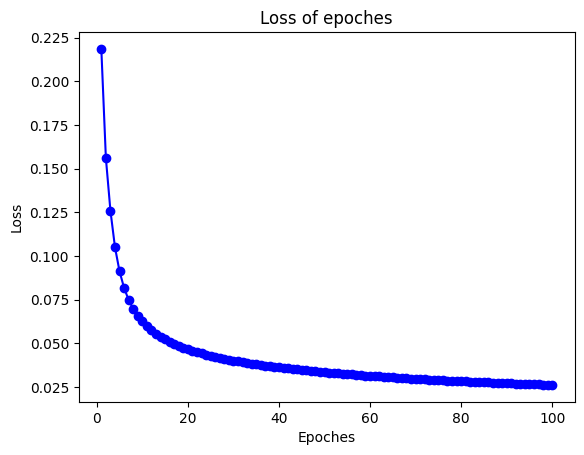

In [14]:
if __name__ == '__main__':
    # < 训练 > (主函数)
    L=[]
    num_hiddens, num_layers, dropout, batch_size, num_steps = 128, 4, 0.1, 128, 20
    lr, num_epochs, device = 0.0005, 100, "cuda" if torch.cuda.is_available() else "cpu"
    ffn_num_inputs, ffn_num_hiddens, num_heads = 128, 256, 8
    key_size, query_size, value_size = 128, 128, 128
    norm_shape = [128]
    samples=None
    train_iter,src_vocab, tgt_vocab = load_data(batch_size, num_steps)
    encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, \
                                 ffn_num_inputs, ffn_num_hiddens, num_heads, num_layers, dropout)
    decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, \
                                 ffn_num_inputs, ffn_num_hiddens, num_heads, num_layers, dropout)
            
    net = EncoderDecoder(encoder, decoder)
    train(net, train_iter, lr, num_epochs,  src_vocab,tgt_vocab, device,num_steps,Go=True)